### Detecting Human Activities Through Smartphone Sensor - Training

##### Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import glob
from tqdm import tqdm
import seaborn as sns
import filecmp
from sklearn.preprocessing import MaxAbsScaler
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import warnings
from sklearn.neighbors import KNeighborsClassifier
import pydot
from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

##### Global Variables

In [2]:
PBAR_FORMAT='{desc:12}{percentage:3.0f}%|{bar:27}[ {n:4d}/{total:4d}, {elapsed}<{remaining}{postfix} ]'

activity_codes_mapping = {'A': 'walking',
                          'B': 'jogging',
                          'C': 'stairs',
                          'D': 'sitting',
                          'E': 'standing',
                          'F': 'typing',
                          'G': 'brushing teeth',
                          'H': 'eating soup',
                          'I': 'eating chips',
                          'J': 'eating pasta',
                          'K': 'drinking from cup',
                          'L': 'eating sandwich',
                          'M': 'kicking soccer ball',
                          'O': 'playing catch tennis ball',
                          'P': 'dribbling basket ball',
                          'Q': 'writing',
                          'R': 'clapping',
                          'S': 'folding clothes'}

# csv file column names
COL_NAMES =  ['id' , 'activity_code' , 'timestamp', 'x', 'y', 'z']
# training verbose
VERBOSE = 1
# rnadom state for split
RANDOM_STATE=12345

##### Extracted Features

In [3]:
features = ['ACTIVITY',
            'X0', # 1st bin fraction of x axis acceleration distribution
            'X1', # 2nd bin fraction ...
            'X2',
            'X3',
            'X4',
            'X5',
            'X6',
            'X7',
            'X8',
            'X9',
            'Y0', # 1st bin fraction of y axis acceleration distribution
            'Y1', # 2nd bin fraction ...
            'Y2',
            'Y3',
            'Y4',
            'Y5',
            'Y6',
            'Y7',
            'Y8',
            'Y9',
            'Z0', # 1st bin fraction of z axis acceleration distribution
            'Z1', # 2nd bin fraction ...
            'Z2',
            'Z3',
            'Z4',
            'Z5',
            'Z6',
            'Z7',
            'Z8',
            'Z9',
            'XAVG', # average sensor value over the window (per axis)
            'YAVG',
            'ZAVG',
            'XPEAK', # Time in milliseconds between the peaks in the wave associated with most activities. heuristically determined (per axis)
            'YPEAK',
            'ZPEAK',
            'XABSOLDEV', # Average absolute difference between the each of the 200 readings and the mean of those values (per axis)
            'YABSOLDEV',
            'ZABSOLDEV',
            'XSTANDDEV', # Standard deviation of the 200 window's values (per axis)  ***BUG!***
            'YSTANDDEV',
            'ZSTANDDEV',
            'XVAR', # Variance of the 200 window's values (per axis)   ***BUG!***
            'YVAR',
            'ZVAR',
            'XMFCC0', # short-term power spectrum of a wave, based on a linear cosine transform of a log power spectrum on a non-linear mel scale of frequency (13 values per axis)
            'XMFCC1',
            'XMFCC2',
            'XMFCC3',
            'XMFCC4',
            'XMFCC5',
            'XMFCC6',
            'XMFCC7',
            'XMFCC8',
            'XMFCC9',
            'XMFCC10',
            'XMFCC11',
            'XMFCC12',
            'YMFCC0', # short-term power spectrum of a wave, based on a linear cosine transform of a log power spectrum on a non-linear mel scale of frequency (13 values per axis)
            'YMFCC1',
            'YMFCC2',
            'YMFCC3',
            'YMFCC4',
            'YMFCC5',
            'YMFCC6',
            'YMFCC7',
            'YMFCC8',
            'YMFCC9',
            'YMFCC10',
            'YMFCC11',
            'YMFCC12',
            'ZMFCC0', # short-term power spectrum of a wave, based on a linear cosine transform of a log power spectrum on a non-linear mel scale of frequency (13 values per axis)
            'ZMFCC1',
            'ZMFCC2',
            'ZMFCC3',
            'ZMFCC4',
            'ZMFCC5',
            'ZMFCC6',
            'ZMFCC7',
            'ZMFCC8',
            'ZMFCC9',
            'ZMFCC10',
            'ZMFCC11',
            'ZMFCC12',
            'XYCOS', # The cosine distances between sensor values for pairs of axes (three pairs of axes)
            'XZCOS',
            'YZCOS',
            'XYCOR', # The correlation between sensor values for pairs of axes (three pairs of axes)
            'XZCOR',
            'YZCOR',
            'RESULTANT', # Average resultant value, computed by squaring each matching x, y, and z value, summing them, taking the square root, and then averaging these values over the 200 readings
            'PARTICIPANT'] # Categirical: 1600 -1650

len(features)


93

##### Dataset

In [4]:
def WISDM_Dataset(DATA_DIR):
    #the duplicate files to be ignored; all identical to 1600
    duplicate_files = [str(i) for i in range(1611, 1618)] # '1611',...'1617'

    # path = r'../dataset/arff_files/' + str(device) + '/' + str(sensor) + '/'
    all_files = glob.glob(DATA_DIR + "/*.arff")

    list_dfs = []

    for filename in all_files:

        if any(dup_fn in filename for dup_fn in duplicate_files):
            continue #ignore the duplicate files
        df = pd.read_csv(filename, names = features, skiprows = 96, index_col=None, header=0)
        list_dfs.append(df)

    all_data = pd.concat(list_dfs, axis=0, ignore_index=True, sort=False)

    return all_data
    

### Training on Watch - Accelerometer

##### Hyper parameters

In [5]:
my_param_grid = {'n_neighbors': [5, 10, 20], 'leaf_size': [20, 30, 40]}
number_of_splits=5 
train_size=0.7
test_size=0.3
DATA_DIR="../dataset/arff_files/watch/accel"

##### Initialize Dataset

In [6]:
all_watch_accel = WISDM_Dataset(DATA_DIR)


# The following columns:'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV' ,'XVAR', 'YVAR', 'ZVAR' are suspected to contain erroneous data: 
# ( e.g. absolute deviation is not of the same order of magnitude of standard deviation; variance is not the square of standard deviation !!!)
# Hence they will be dropped from the dataset
# all_watch_accel.drop(['XSTANDDEV','YSTANDDEV','ZSTANDDEV','XVAR','YVAR','ZVAR'], axis = 1, inplace = True)

# The approach in this analysis will be to see all the participants as a closed united sample population. 
# The purpose of this analysis is not to inquire the inter participant variability.
all_watch_accel.drop('PARTICIPANT', axis = 1, inplace = True)

y = all_watch_accel.ACTIVITY
X = all_watch_accel.drop('ACTIVITY', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size = 0.75, 
                                                    test_size = 0.25,
                                                    shuffle = True, 
                                                    stratify = all_watch_accel.ACTIVITY)

# Temporarily re-unite the train lables to train dataset for further preprocessing steps.
X_train.insert(0, 'Y', y_train)

# it seems that there are few extreme values in the PEAK related features, so, they will be removed
# upper_threshold_XPEAK = X_train.XPEAK.mean() + 9*X_train.XPEAK.std()
# X_train = X_train[X_train.XPEAK < upper_threshold_XPEAK].copy()

# upper_threshold_YPEAK = X_train.YPEAK.mean() + 9*X_train.YPEAK.std()
# X_train = X_train[X_train.YPEAK < upper_threshold_YPEAK].copy()

# upper_threshold_ZPEAK = X_train.ZPEAK.mean() + 9*X_train.ZPEAK.std()
# X_train = X_train[X_train.ZPEAK < upper_threshold_ZPEAK].copy()

# separating y_train
y_train = X_train['Y']
X_train.drop(['Y'], axis = 1, inplace = True)

# rescaling is applied to the features that their absolute values exceed the range of ~1
scaling_transformer = MaxAbsScaler().fit(X_train[['XAVG', 'YAVG', 'ZAVG', 'XPEAK', 'YPEAK', 'ZPEAK', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV', 'RESULTANT']])
X_train[['XAVG', 'YAVG', 'ZAVG', 'XPEAK', 'YPEAK', 'ZPEAK', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV', 'RESULTANT']] = scaling_transformer.transform(X_train[['XAVG', 'YAVG', 'ZAVG', 'XPEAK', 'YPEAK', 'ZPEAK', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV', 'RESULTANT']])

X_test = X_test.copy()
X_test[['XAVG', 'YAVG', 'ZAVG', 'XPEAK', 'YPEAK', 'ZPEAK', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV', 'RESULTANT']] = scaling_transformer.transform(X_test[['XAVG', 'YAVG', 'ZAVG', 'XPEAK', 'YPEAK', 'ZPEAK', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV', 'RESULTANT']])

# resetting the indices
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

##### Training

In [7]:
my_cv = StratifiedShuffleSplit(n_splits=number_of_splits, train_size=train_size, test_size=test_size)
knn_classifier = KNeighborsClassifier()
my_param_grid = my_param_grid
knn_model_gs = GridSearchCV(estimator=knn_classifier, 
                        param_grid=my_param_grid, 
                        cv=my_cv, 
                        scoring='accuracy',
                        verbose = 0,
                        return_train_score = True)
knn_model_gs.fit(X_train, y_train)
knn_best_classifier = knn_model_gs.best_estimator_
print(knn_model_gs.best_params_)
print(knn_model_gs.cv_results_)
print(knn_best_classifier.get_params())

{'leaf_size': 20, 'n_neighbors': 5}
{'mean_fit_time': array([0.02147098, 0.01747618, 0.01646457, 0.01927419, 0.01539536,
       0.01723819, 0.01563873, 0.01779609, 0.01617851]), 'std_fit_time': array([0.0079994 , 0.00467423, 0.00232684, 0.00370957, 0.00179813,
       0.00319666, 0.00276284, 0.00135329, 0.00178682]), 'mean_score_time': array([0.23681965, 0.17117205, 0.18382559, 0.15319495, 0.1669385 ,
       0.18361058, 0.15224886, 0.18224092, 0.19555964]), 'std_score_time': array([0.1548264 , 0.01078264, 0.01743441, 0.0080813 , 0.00082901,
       0.00525011, 0.0100435 , 0.02834273, 0.0179669 ]), 'param_leaf_size': masked_array(data=[20, 20, 20, 30, 30, 30, 40, 40, 40],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value=999999), 'param_n_neighbors': masked_array(data=[5, 10, 20, 5, 10, 20, 5, 10, 20],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value

C:\Users\moush\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


##### Evaluation

Train Accuracy

In [8]:
scores = cross_val_score(knn_best_classifier, X_train, y_train, cv=my_cv, scoring='accuracy')
print(list(scores))

knn_best_classifier.score(X_train, y_train)
y_train_pred = knn_best_classifier.predict(X_train)

print("######################################################################################")
print("train accuracy:", accuracy_score(y_true=y_train, y_pred=y_train_pred))
print("######################################################################################")

[np.float64(0.772801747678864), np.float64(0.7815401419989078), np.float64(0.769797924631349), np.float64(0.7681594756963408), np.float64(0.7768978700163844)]
######################################################################################
train accuracy: 0.8561127499180596
######################################################################################


Confusion Matrix

                           walking  jogging  stairs  sitting  standing  \
walking                        191        0      14        0         0   
jogging                          0      223       1        0         0   
stairs                          18        2     161        0         0   
sitting                          0        1       3      170         3   
standing                         4        2       4       11       169   
typing                           0        0       0        4         2   
brushing teeth                   3        0       2        1         4   
eating soup                      0        0       1        0         0   
eating chips                     0        0       0        4         2   
eating pasta                     1        0       0        3         0   
drinking from cup                0        0       0        5         6   
eating sandwich                  0        0       0        7        11   
kicking soccer ball              8    

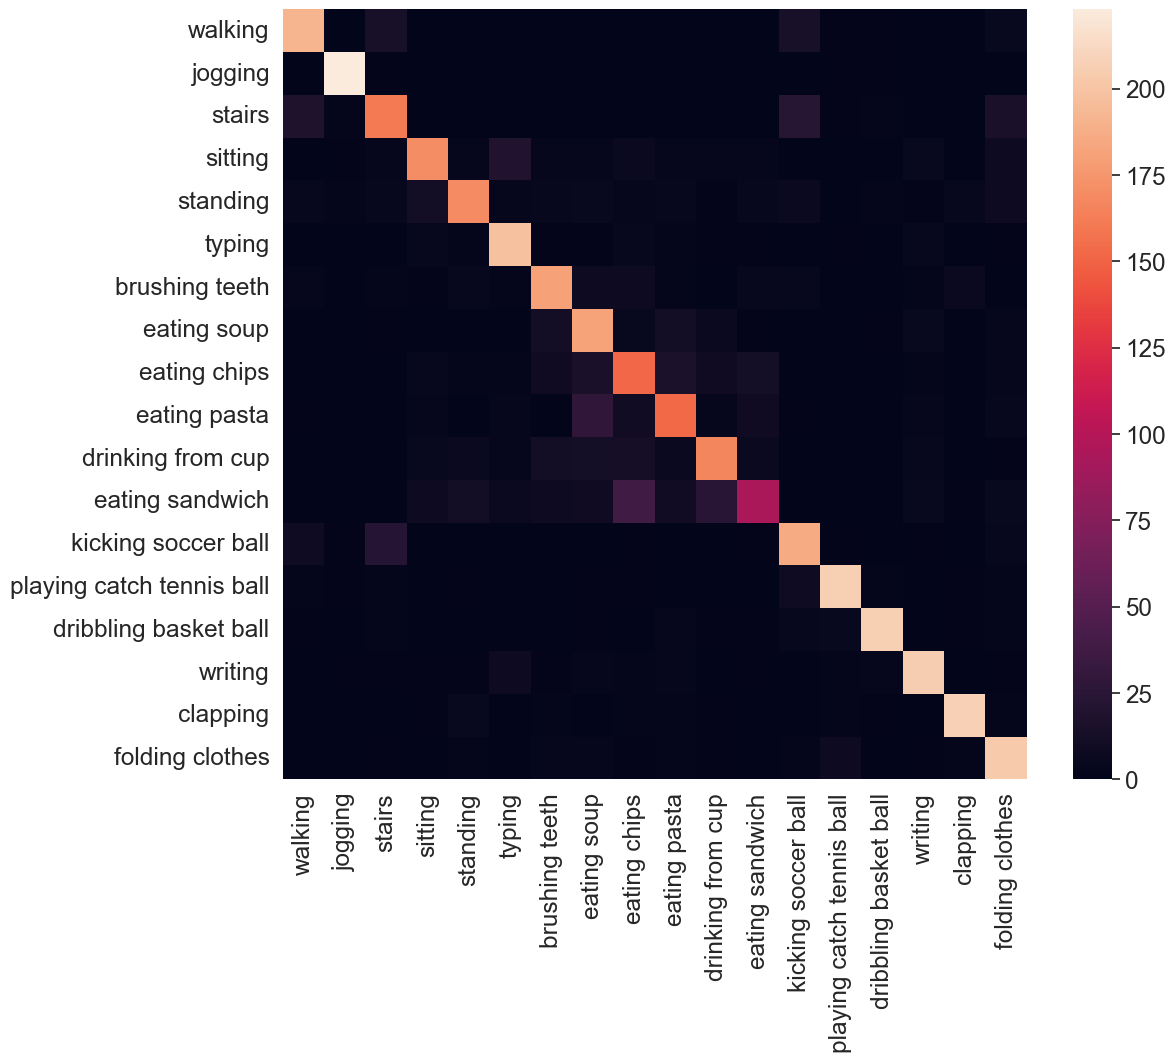

In [9]:
y_test_pred = knn_best_classifier.predict(X_test)
cm = confusion_matrix(y_true=y_test,
                      y_pred=y_test_pred)
    
cm_act = pd.DataFrame(cm,
                      index=knn_best_classifier.classes_,
                      columns=knn_best_classifier.classes_)

cm_act.columns = activity_codes_mapping.values()
cm_act.index = activity_codes_mapping.values()
print(cm_act)
print("######################################################################################")

sns.set(font_scale=1.6)
fig, ax = plt.subplots(figsize=(12,10))
#sns.set(font_scale=1.6)   
_ = sns.heatmap(cm_act)

Accuracy Per Activity

In [10]:
accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(18)],index=activity_codes_mapping.values())
print(accuracy_per_activity)

                                  0
walking                    0.845133
jogging                    0.986726
stairs                     0.725225
sitting                    0.739130
standing                   0.722222
typing                     0.900000
brushing teeth             0.804444
eating soup                0.805310
eating chips               0.672566
eating pasta               0.701835
drinking from cup          0.713675
eating sandwich            0.433180
kicking soccer ball        0.826667
playing catch tennis ball  0.907489
dribbling basket ball      0.907489
writing                    0.883621
clapping                   0.920000
folding clothes            0.890351


C:\Users\moush\AppData\Local\Temp\ipykernel_4640\2644693864.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(18)],index=activity_codes_mapping.values())


Classification Report

In [11]:
print(classification_report(y_true=y_test,
                            y_pred=y_test_pred))
print("######################################################################################")

              precision    recall  f1-score   support

           A       0.84      0.85      0.84       226
           B       0.97      0.99      0.98       226
           C       0.75      0.73      0.74       222
           D       0.82      0.74      0.78       230
           E       0.82      0.72      0.77       234
           F       0.81      0.90      0.85       220
           G       0.78      0.80      0.79       225
           H       0.67      0.81      0.73       226
           I       0.62      0.67      0.65       226
           J       0.71      0.70      0.70       218
           K       0.77      0.71      0.74       234
           L       0.69      0.43      0.53       217
           M       0.75      0.83      0.79       225
           O       0.91      0.91      0.91       227
           P       0.94      0.91      0.92       227
           Q       0.86      0.88      0.87       232
           R       0.93      0.92      0.93       225
           S       0.77    

Test Accuracy

In [12]:
print("test accuracy", accuracy_score(y_true=y_test, y_pred=y_test_pred))

test accuracy 0.7999016715830876


### Training on Watch - Gyroscope

##### Hyper parameters

In [13]:
my_param_grid = {'n_neighbors': [5, 10, 20], 'leaf_size': [20, 30, 40]}
number_of_splits=5 
train_size=0.7
test_size=0.3
DATA_DIR="../dataset/arff_files/watch/gyro"

##### Initialize Dataset

In [14]:
all_watch_gyro = WISDM_Dataset(DATA_DIR)


# The following columns:'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV' ,'XVAR', 'YVAR', 'ZVAR' are suspected to contain erroneous data: 
# ( e.g. absolute deviation is not of the same order of magnitude of standard deviation; variance is not the square of standard deviation !!!)
# Hence they will be dropped from the dataset
# all_watch_gyro.drop(['XSTANDDEV','YSTANDDEV','ZSTANDDEV','XVAR','YVAR','ZVAR'], axis = 1, inplace = True)

# The approach in this analysis will be to see all the participants as a closed united sample population. 
# The purpose of this analysis is not to inquire the inter participant variability.
all_watch_gyro.drop('PARTICIPANT', axis = 1, inplace = True)

y = all_watch_gyro.ACTIVITY
X = all_watch_gyro.drop('ACTIVITY', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size = 0.75, 
                                                    test_size = 0.25,
                                                    shuffle = True, 
                                                    stratify = all_watch_gyro.ACTIVITY)

# Temporarily re-unite the train lables to train dataset for further preprocessing steps.
X_train.insert(0, 'Y', y_train)

# it seems that there are few extreme values in the PEAK related features, so, they will be removed
# upper_threshold_XPEAK = X_train.XPEAK.mean() + 9*X_train.XPEAK.std()
# X_train = X_train[X_train.XPEAK < upper_threshold_XPEAK].copy()

# upper_threshold_YPEAK = X_train.YPEAK.mean() + 9*X_train.YPEAK.std()
# X_train = X_train[X_train.YPEAK < upper_threshold_YPEAK].copy()

# upper_threshold_ZPEAK = X_train.ZPEAK.mean() + 9*X_train.ZPEAK.std()
# X_train = X_train[X_train.ZPEAK < upper_threshold_ZPEAK].copy()

# separating y_train
y_train = X_train['Y']
X_train.drop(['Y'], axis = 1, inplace = True)

# rescaling is applied to the features that their absolute values exceed the range of ~1
scaling_transformer = MaxAbsScaler().fit(X_train[['XAVG', 'YAVG', 'ZAVG', 'XPEAK', 'YPEAK', 'ZPEAK', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV', 'RESULTANT']])
X_train[['XAVG', 'YAVG', 'ZAVG', 'XPEAK', 'YPEAK', 'ZPEAK', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV', 'RESULTANT']] = scaling_transformer.transform(X_train[['XAVG', 'YAVG', 'ZAVG', 'XPEAK', 'YPEAK', 'ZPEAK', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV', 'RESULTANT']])

X_test = X_test.copy()
X_test[['XAVG', 'YAVG', 'ZAVG', 'XPEAK', 'YPEAK', 'ZPEAK', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV', 'RESULTANT']] = scaling_transformer.transform(X_test[['XAVG', 'YAVG', 'ZAVG', 'XPEAK', 'YPEAK', 'ZPEAK', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV', 'RESULTANT']])

# resetting the indices
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

##### Training

In [15]:
my_cv = StratifiedShuffleSplit(n_splits=number_of_splits, train_size=train_size, test_size=test_size)
knn_classifier = KNeighborsClassifier()
my_param_grid = my_param_grid
knn_model_gs = GridSearchCV(estimator=knn_classifier, 
                        param_grid=my_param_grid, 
                        cv=my_cv, 
                        scoring='accuracy',
                        verbose = 0,
                        return_train_score = True)
knn_model_gs.fit(X_train, y_train)
knn_best_classifier = knn_model_gs.best_estimator_
print(knn_model_gs.best_params_)
print(knn_model_gs.cv_results_)
print(knn_best_classifier.get_params())

{'leaf_size': 20, 'n_neighbors': 5}
{'mean_fit_time': array([0.0335588 , 0.0135592 , 0.00819445, 0.01665168, 0.0164465 ,
       0.01557193, 0.01476388, 0.01811676, 0.01729255]), 'std_fit_time': array([0.02368355, 0.00362782, 0.00685845, 0.00293537, 0.00118463,
       0.0002837 , 0.00322495, 0.00432305, 0.00290835]), 'mean_score_time': array([0.17753525, 0.16828341, 0.20053558, 0.16086516, 0.16388226,
       0.15885839, 0.15038605, 0.15152087, 0.1765276 ]), 'std_score_time': array([0.04276791, 0.01398329, 0.01109748, 0.01440299, 0.02108593,
       0.02072311, 0.02475899, 0.0166719 , 0.02672064]), 'param_leaf_size': masked_array(data=[20, 20, 20, 30, 30, 30, 40, 40, 40],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value=999999), 'param_n_neighbors': masked_array(data=[5, 10, 20, 5, 10, 20, 5, 10, 20],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value

##### Evaluation

Train Accuracy

In [16]:
scores = cross_val_score(knn_best_classifier, X_train, y_train, cv=my_cv, scoring='accuracy')
print(list(scores))

knn_best_classifier.score(X_train, y_train)
y_train_pred = knn_best_classifier.predict(X_train)

print("######################################################################################")
print("train accuracy:", accuracy_score(y_true=y_train, y_pred=y_train_pred))
print("######################################################################################")

[np.float64(0.5816077953714982), np.float64(0.5706455542021924), np.float64(0.5843483556638246), np.float64(0.5685140073081608), np.float64(0.5736906211936662)]
######################################################################################
train accuracy: 0.713959437237347
######################################################################################


Confusion Matrix

                           walking  jogging  stairs  sitting  standing  \
walking                        157        5      12        0         0   
jogging                          3      191       1        0         0   
stairs                          19       10      78        0         1   
sitting                          2        1       2       86        37   
standing                         1        1       1       37        90   
typing                           1        0       0        9         8   
brushing teeth                   6        2       4        4         2   
eating soup                      0        0       0        9        12   
eating chips                     1        0       2        8        13   
eating pasta                     0        0       1        4         5   
drinking from cup                0        0       0       18        18   
eating sandwich                  3        0       7       16        10   
kicking soccer ball              8    

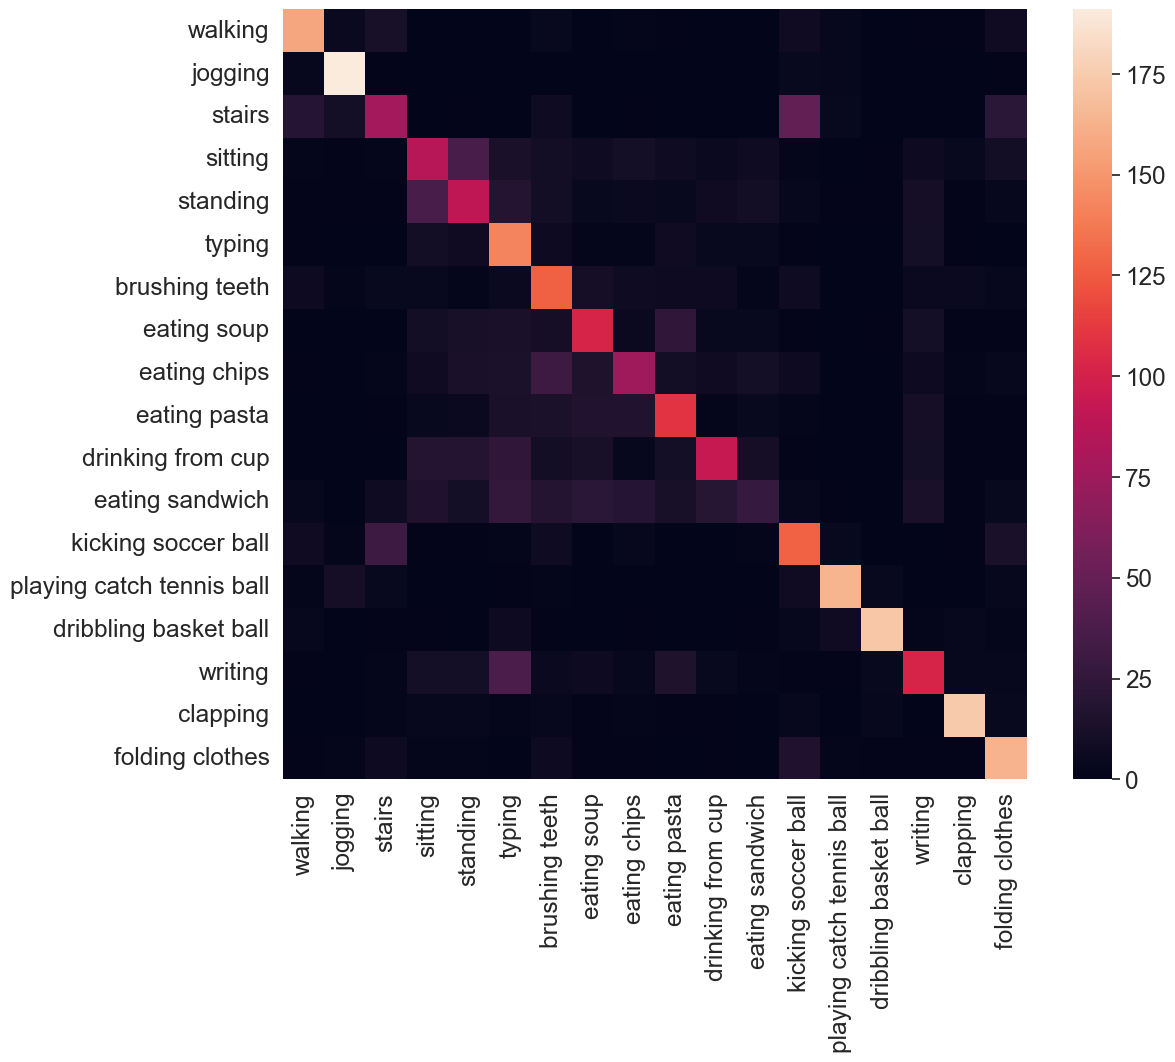

In [17]:
y_test_pred = knn_best_classifier.predict(X_test)
cm = confusion_matrix(y_true=y_test,
                      y_pred=y_test_pred)
    
cm_act = pd.DataFrame(cm,
                      index=knn_best_classifier.classes_,
                      columns=knn_best_classifier.classes_)

cm_act.columns = activity_codes_mapping.values()
cm_act.index = activity_codes_mapping.values()
print(cm_act)
print("######################################################################################")

sns.set(font_scale=1.6)
fig, ax = plt.subplots(figsize=(12,10))
#sns.set(font_scale=1.6)   
_ = sns.heatmap(cm_act)

Accuracy Per Activity

In [18]:
accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(18)],index=activity_codes_mapping.values())
print(accuracy_per_activity)

                                  0
walking                    0.777228
jogging                    0.940887
stairs                     0.412698
sitting                    0.413462
standing                   0.434783
typing                     0.717172
brushing teeth             0.628713
eating soup                0.515152
eating chips               0.374384
eating pasta               0.542289
drinking from cup          0.443396
eating sandwich            0.134328
kicking soccer ball        0.630542
playing catch tennis ball  0.824121
dribbling basket ball      0.843902
writing                    0.485714
clapping                   0.861386
folding clothes            0.791262


C:\Users\moush\AppData\Local\Temp\ipykernel_4640\2644693864.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(18)],index=activity_codes_mapping.values())


Classification Report

In [19]:
print(classification_report(y_true=y_test,
                            y_pred=y_test_pred))
print("######################################################################################")

              precision    recall  f1-score   support

           A       0.75      0.78      0.77       202
           B       0.85      0.94      0.89       203
           C       0.51      0.41      0.45       189
           D       0.41      0.41      0.41       208
           E       0.42      0.43      0.43       207
           F       0.45      0.72      0.55       198
           G       0.47      0.63      0.54       202
           H       0.51      0.52      0.51       198
           I       0.48      0.37      0.42       203
           J       0.53      0.54      0.54       201
           K       0.60      0.44      0.51       212
           L       0.33      0.13      0.19       201
           M       0.52      0.63      0.57       203
           O       0.86      0.82      0.84       199
           P       0.92      0.84      0.88       205
           Q       0.54      0.49      0.51       210
           R       0.87      0.86      0.87       202
           S       0.67    

Test Accuracy

In [20]:
print("test accuracy", accuracy_score(y_true=y_test, y_pred=y_test_pred))

test accuracy 0.5982460948204987
